In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# file_location="C:\\Users\\Divya Krishnan\\Desktop\\";

file_location = './'

oos_data = pd.read_csv(file_location + "daily_product_oos (2).csv")

sales_data = pd.read_csv(file_location + "daily_product_sales (2).csv")
product_promotion_data = pd.read_csv(file_location +'product_promotions.csv')
product_brand_map = pd.read_csv(file_location + "product_brand_map.csv")


#data1.head()


In [ ]:
product_brand_map = np.array(product_brand_map['0.1']);

### Renaming Columns

In [ ]:
col_names = sales_data.columns.values;
col_names[0] = "product_ids";
sales_data.columns = col_names;

col_names = oos_data.columns.values;
col_names[0] = "product_ids";
oos_data.columns = col_names;

In [ ]:
def get_matrix_from_vector(vec, T,S):
    m = len(vec);
    n = int( 1/S*(m-T+1) );
    data_mat = np.zeros((n, T));
    for i in range(0, n):
            f=int(S*i)
            data_mat[i, :] = vec[f:f+T]   
    return data_mat

In [ ]:
def normalize_vector(vec):
    vec = (vec - np.mean(vec))/np.std(vec);
    return vec;

In [ ]:
def systematic_test_train_split(data_vector, fraction_test = 0.2, T = 30, S = 15, normalize=True, test_S = 1):

    #random sampling
    #missing.append((Data.isnull().sum()))
    #T=40
    #Data1=get_matrix_from_vector(Data,T=40,S=1)
    #X=Data1[:,0:T-2]
    #Y=Data1[:,T-1]
    
    if(normalize):
        data_vector = normalize_vector(data_vector)
    
    #systematic sampling

    k = int(data_vector.shape[0] * fraction_test)
    
    data_train = data_vector[0: -k];
    train_matrix = get_matrix_from_vector(data_train, T, S)
    x_train = train_matrix[:,0 : -1];
    y_train = train_matrix[:, -1];
    
    data_test = data_vector[ -k:];
    test_matrix = get_matrix_from_vector(data_test, T, S = test_S)
    x_test = test_matrix[:, 0:-1]
    y_test = test_matrix[:, -1]
    
    # x_train1, x_test1, y_train1, y_test1 = train_test_split(X,Y, test_size=0.20)

    return (x_train, y_train, x_test, y_test)


In [ ]:
#RF regression
def random_forest(x_train,y_train,x_test,y_test):
    
    clf = RandomForestRegressor()

    clf.fit(x_train, y_train)

    predictions_sys = clf.predict(x_test)
    predictions_tr_sys = clf.predict(x_train)


    #MSE of test and train in RF

    MSE_train = metrics.mean_squared_error(y_train,predictions_tr_sys)
    MSE_test = metrics.mean_squared_error(y_test,predictions_sys)

    return(MSE_test,MSE_train)





In [ ]:
#linear Regression

def linear_regression(x_train,y_train,x_test,y_test):
    
    clf = LinearRegression()

    clf.fit(x_train, y_train)

    predictions_sys = clf.predict(x_test)
    predictions_tr_sys = clf.predict(x_train)


    MSE_train = metrics.mean_squared_error(y_train,predictions_tr_sys)
    MSE_test = metrics.mean_squared_error(y_test,predictions_sys)

    return MSE_test, MSE_train

In [ ]:
def ampute_data_vector_with_past_mean(data_vector, L = 10):
    #L refers to how much in the past we should look to calculate mean
    for i,x in enumerate(data_vector):
        if pd.isnull(x):
            if i==0:
                data_vector[i] = 0;
            else:
                start_index = i-L if i>=L else 0;
                data_vector[i] = np.mean(data_vector[start_index:i]);
    return data_vector

In [ ]:
product_ids = sales_data["product_ids"];
sales_all_product_vectors = sales_data.drop("product_ids", axis = 1)
oos_all_product_vectors = oos_data.drop("product_ids", axis = 1)

In [ ]:
max_product_number = sales_all_product_vectors.shape[0]; #uncomment for the entire dataset
# max_product_number = 200;

### Amputing Data for Sales

In [ ]:
np.sum(np.sum(np.array(pd.isnull(sales_all_product_vectors))[:max_product_number, :])) ##checking number of null values in the data

In [ ]:
for i in range(max_product_number):
    sales_all_product_vectors.iloc[i] = ampute_data_vector_with_past_mean(sales_all_product_vectors.iloc[i], L=10)

In [ ]:
np.sum(np.sum(np.array(pd.isnull(sales_all_product_vectors))[:max_product_number, :]))

### Preparing Dataset

In [ ]:
T = 31;
S = 15;
test_S = 15;
fraction_test = 0.2;
number_of_groups = 250;
normalize = True;

In [18]:
add_oos_features = True;


In [19]:
product_to_group_mapping = np.genfromtxt('product_to_cluster_mapping_k=250.csv', delimiter=',');

In [20]:
product_to_group_mapping

array([249., 228., 115., ...,  14.,  64., 145.])

In [21]:
number_per_group = np.unique(product_to_group_mapping, return_counts=True)[1];

(array([ 7.,  3.,  1.,  0.,  3.,  2.,  0.,  3.,  4.,  6.,  3.,  5.,  6.,
         1.,  4.,  3., 12.,  8.,  6.,  3.,  9.,  8.,  9.,  6., 12., 14.,
         3., 15., 10., 12.,  5.,  6.,  7.,  8.,  4.,  9.,  4.,  9.,  5.,
         0.,  6.,  5.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1.  ,  2.62,  4.24,  5.86,  7.48,  9.1 , 10.72, 12.34, 13.96,
        15.58, 17.2 , 18.82, 20.44, 22.06, 23.68, 25.3 , 26.92, 28.54,
        30.16, 31.78, 33.4 , 35.02, 36.64, 38.26, 39.88, 41.5 , 43.12,
        44.74, 46.36, 47.98, 49.6 , 51.22, 52.84, 54.46, 56.08, 57.7 ,
        59.32, 60.94, 62.56, 64.18, 65.8 , 67.42, 69.04, 70.66, 72.28,
        73.9 , 75.52, 77.14, 78.76, 80.38, 82.  ]),
 <a list of 50 Patch objects>)

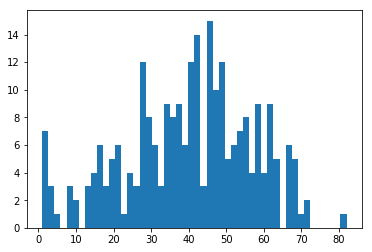

In [22]:
plt.hist(number_per_group, bins = 50)

In [23]:
def get_group_train_test_matrices(df_of_series, fraction_test = 0.2, T = 30, S = 15, normalize=True, test_S = 1):
    n_products = df_of_series.shape[0];
    x_train_one_product, y_train_one_product, x_test_one_product, y_test_one_product = systematic_test_train_split(df_of_series.iloc[0], 
                                                                               fraction_test, T, S , normalize, test_S);
        
    if(n_products == 1):
        return x_train_one_product, y_train_one_product, x_test_one_product, y_test_one_product
    
    n_train_per_product = len(y_train_one_product);
    n_test_per_product = len(y_test_one_product);
    
    X_train = np.zeros([n_train_per_product * n_products, T-1]);
    X_test = np.zeros([n_test_per_product * n_products, T-1]);
    y_train = np.zeros(n_train_per_product * n_products);
    y_test = np.zeros(n_test_per_product * n_products);
    
    i= 0;
    X_train[i*n_train_per_product: (i+1)*n_train_per_product, :] = x_train_one_product;
    y_train[i*n_train_per_product: (i+1)*n_train_per_product] = y_train_one_product;
    X_test[i*n_test_per_product: (i+1)*n_test_per_product, :] = x_test_one_product;
    y_test[i*n_test_per_product: (i+1)*n_test_per_product] = y_test_one_product;
    
    for i in range(1, n_products):
        x_train_one_product, y_train_one_product, x_test_one_product, y_test_one_product = systematic_test_train_split(df_of_series.iloc[i], 
                                                                               fraction_test, T, S , normalize, test_S);
        X_train[i*n_train_per_product: (i+1)*n_train_per_product, :] = x_train_one_product;
        y_train[i*n_train_per_product: (i+1)*n_train_per_product] = y_train_one_product;
        X_test[i*n_test_per_product: (i+1)*n_test_per_product, :] = x_test_one_product;
        y_test[i*n_test_per_product: (i+1)*n_test_per_product] = y_test_one_product;
    
    return X_train, y_train, X_test, y_test
    
    

#### For Campaign Data

since we're just building and evaluating the model, I decided not to store the huge X matrices for all groups. We will just make the data, build model and evaluate

In [24]:
# X_train_dict = {};
# y_train_dict = {};
# X_test_dict = {};
# y_test_dict = {};

# for group_number in range(number_of_groups):
#     X_train, y_train, X_test, y_test = get_group_train_test_matrices( sales_all_product_vectors.iloc[ np.where(product_to_group_mapping == group_number)[0]], 
#                                                                     fraction_test, T, S, normalize);
#     X_train_dict[group_number] = X_train;
#     y_train_dict[group_number] = y_train;
#     X_test_dict[group_number] = X_test;
#     y_test_dict[group_number] = y_test;

### Fitting Model

In [25]:
lr_mse_train = np.zeros(number_of_groups);
lr_mse_test = np.zeros(number_of_groups);
rf_mse_train = np.zeros(number_of_groups);
rf_mse_test = np.zeros(number_of_groups);

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  1.,  3.,  4.,
        13., 10., 12., 15., 15., 14., 20., 26., 13., 21., 11.,  6.,  6.,
         9.,  6.,  3.,  4.,  2.,  6.,  3.,  2.,  1.,  2.,  4.,  1.,  1.,
         1.,  0.,  1.,  1.,  1.,  3.,  1.,  0.,  0.,  0.,  3.]),
 array([0.21162043, 0.23647665, 0.26133288, 0.2861891 , 0.31104533,
        0.33590155, 0.36075778, 0.385614  , 0.41047022, 0.43532645,
        0.46018267, 0.4850389 , 0.50989512, 0.53475135, 0.55960757,
        0.58446379, 0.60932002, 0.63417624, 0.65903247, 0.68388869,
        0.70874492, 0.73360114, 0.75845736, 0.78331359, 0.80816981,
        0.83302604, 0.85788226, 0.88273848, 0.90759471, 0.93245093,
        0.95730716, 0.98216338, 1.00701961, 1.03187583, 1.05673205,
        1.08158828, 1.1064445 , 1.13130073, 1.15615695, 1.18101318,
        1.2058694 , 1.23072562, 1.25558185, 1.28043807, 1.3052943 ,
        1.33015052, 1.35500675, 1.37986297, 1.40471919, 1.42957542,
        1.45443164]),
 <a list of 50

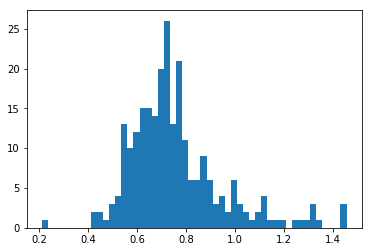

In [26]:
for group_number in range(number_of_groups):
    print(group_number)
    x_train, y_train, x_test, y_test = get_group_train_test_matrices( sales_all_product_vectors.iloc[ np.where(product_to_group_mapping == group_number)[0]], 
                                                                    fraction_test, T, S, normalize, test_S);
    
    if(add_oos_features):
        x_train_oos, dummy, x_test_oos, dummy = get_group_train_test_matrices( oos_all_product_vectors.iloc[ np.where(product_to_group_mapping == group_number)[0]], 
                                                                    fraction_test, T, S, False, test_S);
        x_train = np.hstack([x_train, x_train_oos]);
        x_test = np.hstack( [x_test, x_test_oos]);
  
        
        
    lr_mse_test[group_number], lr_mse_train[group_number] = linear_regression(x_train, y_train, x_test, y_test);
    rf_mse_test[group_number], rf_mse_train[group_number] = random_forest(x_train, y_train, x_test, y_test);
plt.hist(rf_mse_test, bins = 50)

### Checking MSE Values

In [27]:
np.average(lr_mse_test, weights=number_per_group[:number_of_groups]), np.average(lr_mse_train, weights = number_per_group[:number_of_groups])

(0.6662498428269256, 0.2921684130759358)

In [28]:
np.average(rf_mse_test, weights=number_per_group[:number_of_groups]), np.average(rf_mse_train, weights = number_per_group[:number_of_groups])

(0.7372335009771738, 0.059636603786564386)